# Example - Computing photon rates via KDE

*This notebook is part of smFRET burst analysis software [FRETBursts](http://tritemio.github.io/FRETBursts/).*

> This notebook explores computing the photon rate with different methods.
>
> For a complete tutorial on burst analysis see 
> [FRETBursts - us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).

# Load Data

In [1]:
from fretbursts import *
from fretbursts.phtools import phrates
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.5+31.g06e6f01).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1101/039198 

--------------------------------------------------------------


In [2]:
url = 'http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


In [3]:
filename = "data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"

In [4]:
d = loader.photon_hdf5(filename)
#bpl.plot_alternation_hist(d)
loader.alex_apply_period(d)
d.calc_bg(fun=bg.exp_fit, time_s=20, tail_min_us='auto', F_bg=1.7)
d.burst_search()

#donor: 721537  #acceptor: 1537985 

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


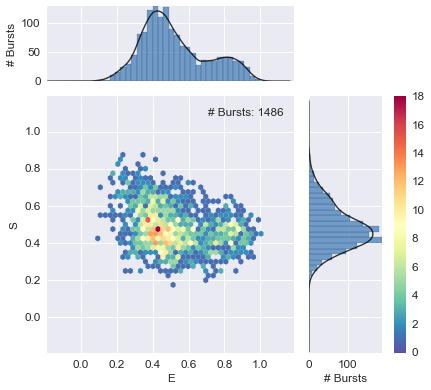

In [5]:
ds1 = d.select_bursts(select_bursts.size, th1=30)
ds = ds1.select_bursts(select_bursts.naa, th1=30)

alex_jointplot(ds);

In [6]:
ph = d.ph_times_m[0]

In [7]:
tau = 100e-6/d.clk_p
tau

8000.000000000001

# KDE considerations

For start, let's compute the instantaneous photon-rate via KDE on synthetic timestamps. We compare different kernels: laplace distribution (i.e. exponential), Gaussian and rectangular.

In [8]:
%matplotlib inline

In [9]:
tau = 5000

In [10]:
(t.size - 1) / t.max()

NameError: name 't' is not defined

(0.9, 1.0)

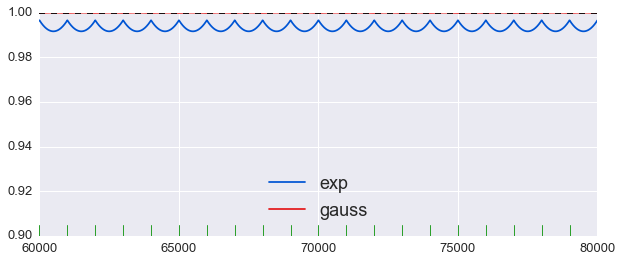

In [112]:
true_rate = 0.001
num_times = 140
t = np.arange(0, num_times/true_rate, 1/true_rate, dtype=np.int64)
tx = np.arange(0, t.max(), 0.001*(t[1] - t[0]), dtype=np.int64)
assert np.allclose(true_rate, (t.size - 1) / t.max())

rate_rect = phrates.kde_rect(t, tau, tx)
rate_gauss = phrates.kde_gaussian(t, tau, tx)
rate_laplace = phrates.kde_laplace(t, tau, tx)

fig, ax = plt.subplots(figsize=(10, 4))
plot(tx, rate_laplace / (2*tau) / true_rate, label='exp')
#plot(tx, rate_rect / tau / true_rate, label='rect')
plot(tx, rate_gauss / (2.5*tau) / true_rate, label='gauss')
plt.axhline(1, ls='--', color='k')
plt.legend(loc='lower center', fontsize=18)
sns.distplot(t, rug=True, kde=False, hist=False);
xmin = (num_times / 2 - 10) / true_rate
xmax = (num_times / 2 + 10) / true_rate
plt.xlim(xmin, xmax)
plt.ylim(0.9)

In [113]:
rate_gauss.max() / (2.5*tau) / true_rate, rate_laplace.max() / (2*tau) / true_rate

(0.99998848106288796, 0.99657072136195257)

In [91]:
rate_laplace.max() / (2*tau)

0.0010746864051641961

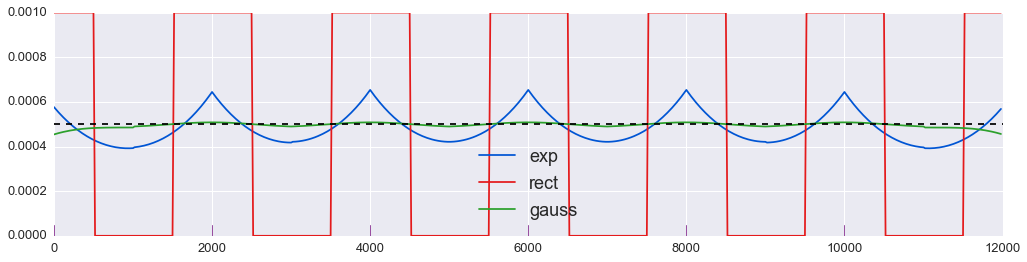

In [92]:
t = np.arange(0, 14000, 2000, dtype=np.int64)
tx = np.arange(0, t.max(), 0.01*(t[1] - t[0]), dtype=np.int64)
true_rate = (t.size - 1) / t.max()

rate_rect = phrates.kde_rect(t, tau, tx)
rate_gauss = phrates.kde_gaussian(t, tau, tx)
rate_laplace = phrates.kde_laplace(t, tau, tx)

fig, ax = plt.subplots(figsize=(17, 4))
plot(tx, rate_laplace / (2*tau), label='exp')
plot(tx, rate_rect / tau, label='rect')
plot(tx, rate_gauss / (2.5*tau), label='gauss')
plt.axhline(true_rate, ls='--', color='k')
plt.legend(loc='lower center', fontsize=18)
sns.distplot(t, rug=True, kde=False, hist=False)

In [209]:
tau = 0.020
true_rate = 1000
num_times = 1000
time_max = num_times / true_rate

np.random.seed(3)
dt = np.random.exponential(scale=1/true_rate, size=(num_times - 1))
t = np.cumsum(dt)
tx = t

In [210]:
print('Number of photons in 1 tau:', true_rate * tau)

Number of photons in 1 tau: 20.0


In [ ]:
rate_rect = phrates.nb.kde_rect_numba(t, tau*5, tx)
rate_gauss = phrates.nb.kde_gaussian_numba(t, tau, tx)
rate_laplace = phrates.nb.kde_laplace_numba(t, tau, tx)
m = 100
rate_x = (m - 2) / (t[m-1:] - t[:-(m-1)])

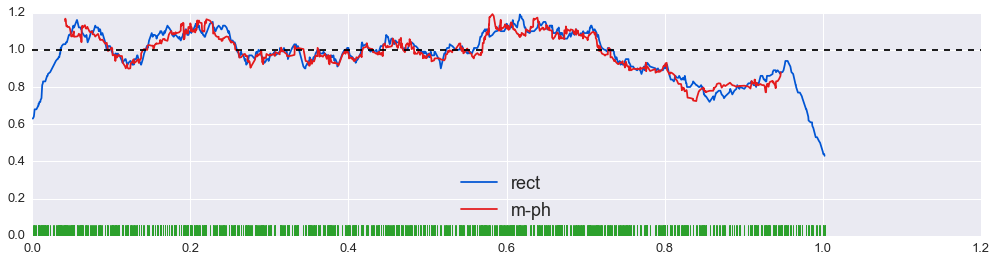

In [218]:
fig, ax = plt.subplots(figsize=(17, 4))
plot(tx, rate_rect / (5*tau) / true_rate, label='rect')
plot(t[m//2:-(m-m//2-1)], rate_x / true_rate, label='m-ph')
plt.axhline(1, ls='--', color='k')
plt.legend(loc='lower center', fontsize=18)
sns.distplot(t, rug=True, kde=False, hist=False);

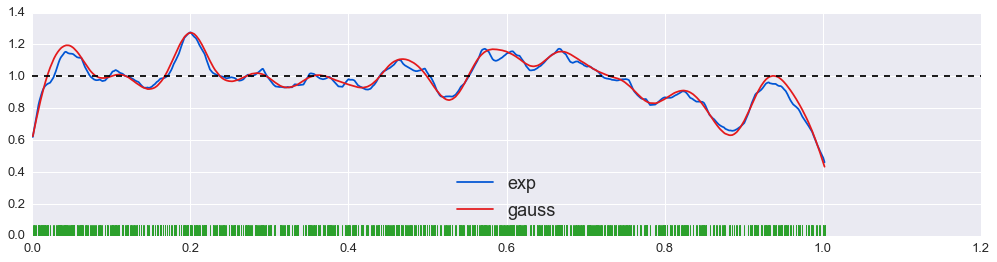

In [219]:
fig, ax = plt.subplots(figsize=(17, 4))
plot(tx, rate_laplace / (2*tau) / true_rate, label='exp')
plot(tx, rate_gauss / (2.5*tau) / true_rate, label='gauss')
plt.axhline(1, ls='--', color='k')
plt.legend(loc='lower center', fontsize=18)
sns.distplot(t, rug=True, kde=False, hist=False);

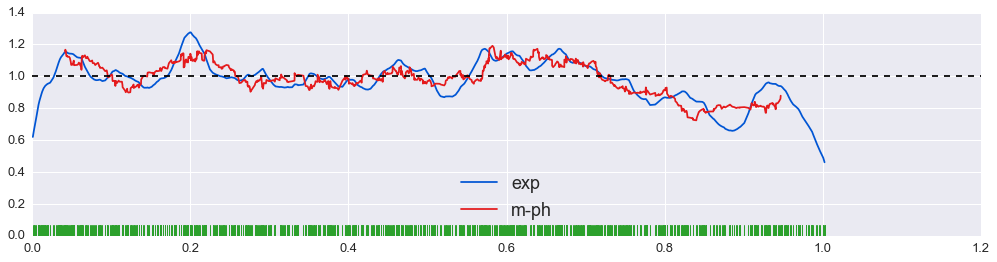

In [221]:
fig, ax = plt.subplots(figsize=(17, 4))
plot(tx, rate_laplace / (2*tau) / true_rate, label='exp')
plot(t[m//2:-(m-m//2-1)], rate_x / true_rate, label='m-ph')
plt.axhline(1, ls='--', color='k')
plt.legend(loc='lower center', fontsize=18)
sns.distplot(t, rug=True, kde=False, hist=False);

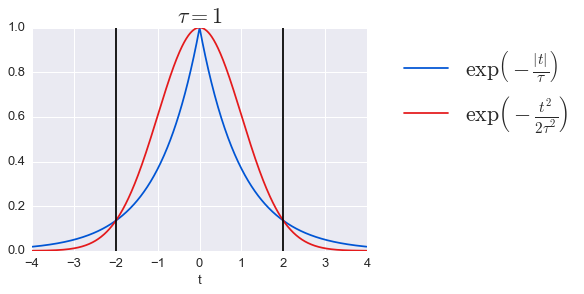

In [143]:
tau = 1
tau2 = 2 * (tau**2)

xx = np.arange(-4*tau, 4*tau, tau/100)
y1 = np.exp(-np.abs(xx) / tau)
y2 = np.exp(-xx**2 / tau2)

plt.plot(xx,y1, label=r'$\exp \left( - \frac{|t|}{\tau} \right)$')
plt.plot(xx, y2, label=r'$\exp \left( - \frac{t^2}{2\tau^2} \right)$')
plt.axvline(2*tau, color='k')
plt.axvline(-2*tau, color='k')
plt.xlabel('t')
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 1), loc=2)
plt.title(r'$\tau = %d$' % tau, fontsize=22);

## Notes on Kernel Shape

The Gaussian kernel gives a more accurate rate estimation with very little dependence on the position where the KDE is evaluated. On the contrary, with symmetric exponential kernel (laplace distribution), there is always a strong dependence on the evaluation position. In particular, when rates are estimated at the timestamps positions, the rates are systematically over-estimated (i.e. the peak is always sampled).

For Gaussian kernel, given a $\tau$, the rate estimation will be accurate for rates higher than $1/(2\,\tau)$ counts-per-second. For lower rates, the estimation will strongly depend on where the KDE is evaluated. A similar condition can be also found for the exponential kernel, but this case the rate will aways be strongly dependent on the position.